# Material Backorder prediction: Custom Stacking Classifier

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
 
 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,classification_report,f1_score,recall_score
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
 
 #from imblearn.over_sampling import SMOTE
from collections import Counter
from prettytable import PrettyTable
import joblib

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 30 kB/s 


In [ ]:
#get data
!wget --header="Host: raw.githubusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.106 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://colab.research.google.com/" "https://raw.githubusercontent.com/rodrigosantis1/backorder_prediction/58e81b4a1ac67db3605456a5fedfe40eaa9d76ad/dataset.rar" -c -O 'dataset.rar'

--2021-09-05 02:28:37--  https://raw.githubusercontent.com/rodrigosantis1/backorder_prediction/58e81b4a1ac67db3605456a5fedfe40eaa9d76ad/dataset.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24741696 (24M) [application/octet-stream]
Saving to: ‘dataset.rar’

dataset.rar         100%[===================>]  23.59M   120MB/s    in 0.2s    

2021-09-05 02:28:39 (120 MB/s) - ‘dataset.rar’ saved [24741696/24741696]



In [ ]:
! unrar x '/content/dataset.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/dataset.rar

Extracting  Kaggle_Training_Dataset_v2.csv                                 0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87%  OK 
Extracting  Kaggle_Test_Dataset_v2.csv                                    87% 88% 89% 90%

In [ ]:
#data
data=pd.read_csv('/content/Kaggle_Training_Dataset_v2.csv')
test=pd.read_csv('/content/Kaggle_Test_Dataset_v2.csv')
print('shape of training data:',data.shape)
print('shape of testing data:',test.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


shape of training data: (1687861, 23)
shape of testing data: (242076, 23)


In [ ]:
#dropping last row #nan values
data=data.drop(data.index[-1])
test=test.drop(test.index[-1])

In [ ]:
sample=data[data['went_on_backorder']==1].head(3)
sample

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
143,1111623,0.0,8.0,0.0,2.0,3.0,5.0,0.0,3.0,3.0,3.0,2.0,0,0.0,0.68,0.58,0.0,0,0,1,1,0,1
173,1111652,24.0,8.0,0.0,3456.0,3456.0,3456.0,10.0,39.0,68.0,93.0,7.0,0,0.0,1.00,0.95,1.0,0,0,1,1,0,1
176,1111655,-55.0,8.0,2.0,428.0,526.0,606.0,25.0,100.0,205.0,387.0,52.0,0,0.0,-99.00,-99.00,56.0,0,0,0,1,0,1


In [ ]:
sample=sample.append(data[data['went_on_backorder']==0].head(3))
sample

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
143,1111623,0.0,8.0,0.0,2.0,3.0,5.0,0.0,3.0,3.0,3.0,2.0,0,0.0,0.68,0.58,0.0,0,0,1,1,0,1
173,1111652,24.0,8.0,0.0,3456.0,3456.0,3456.0,10.0,39.0,68.0,93.0,7.0,0,0.0,1.00,0.95,1.0,0,0,1,1,0,1
176,1111655,-55.0,8.0,2.0,428.0,526.0,606.0,25.0,100.0,205.0,387.0,52.0,0,0.0,-99.00,-99.00,56.0,0,0,0,1,0,1
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,0,0,0,1,0,0
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.99,0.99,0.0,0,0,0,1,0,0
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0


In [ ]:
sample.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_3_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,deck_risk,stop_auto_buy,went_on_backorder
sku,,,,,,,,,,,,
1111623,0.0,8.0,0.0,2.0,3.0,2.0,0.0,0.68,0.58,0,1,1
1111652,24.0,8.0,0.0,3456.0,39.0,7.0,0.0,1.00,0.95,0,1,1
1111655,-55.0,8.0,2.0,428.0,100.0,52.0,0.0,-99.00,-99.00,0,1,1
1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-99.00,-99.00,0,1,0
1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.99,0.99,0,1,0


In [ ]:
data=data.append(test,ignore_index=True).sample(frac=1)
print(data.shape)

(1929935, 23)


In [ ]:
from sklearn.model_selection import train_test_split
data,test=train_test_split(data,test_size=0.2,stratify=data['went_on_backorder'],random_state=33)
print(data.shape,test.shape)

(1543948, 23) (385987, 23)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.to_csv('/content/drive/MyDrive/CS1_bo/data.csv')
test.to_csv('/content/drive/MyDrive/CS1_bo/test.csv')

In [ ]:
#replacing 'Yes'/'No' with 0/1
#train
for feat in data.columns:
  if data[feat].dtype=='O':
    data[feat]=data[feat].replace({'Yes': 1,'No': 0})
#test
for feat in test.columns:
  if test[feat].dtype=='O':
    test[feat]=test[feat].replace({'Yes': 1,'No': 0})

In [ ]:

# imputing lead-time
med=np.median(data[data['lead_time'].notnull()]['lead_time'])
data['lead_time'].fillna(med,inplace=True)
test['lead_time'].fillna(med,inplace=True)

#imputing 'perf_6_month_avg'
med=np.median(data[data['perf_6_month_avg']!=-99]['perf_6_month_avg'])
data['perf_6_month_avg'] = data['perf_6_month_avg'].replace([-99],med)
test['perf_6_month_avg'] = test['perf_6_month_avg'].replace([-99],med)

#imputing 'perf_12_month_avg'
med=np.median(data[data['perf_12_month_avg']!=-99]['perf_12_month_avg'])
data['perf_12_month_avg'] = data['perf_12_month_avg'].replace([-99],med)
test['perf_12_month_avg'] = test['perf_12_month_avg'].replace([-99],med)

In [ ]:
print('null values in train:',data.isnull().sum().sum())
print('null values in test:',test.isnull().sum().sum())

null values in train: 0
null values in test: 0


# Feature Engineering 

In [ ]:
# reorder point is that level of inventory where the business need to place an order before consuming safetystock/min_bank
data['reorder_point']=((data['sales_3_month']/30)*data['lead_time'])+data['min_bank']
test['reorder_point']=((test['sales_3_month']/30)*test['lead_time'])+test['min_bank']

#how much inventory is left to reach reorder point
data['usable_stock']=data['national_inv']-data['reorder_point']
test['usable_stock']=test['national_inv']-test['reorder_point']

#is usable stock negative?
data['neg_stock']=(data['usable_stock']<0).astype('int32')
test['neg_stock']=(test['usable_stock']<0).astype('int32')

#is usable stock zero?
data['zero_stock']=(data['usable_stock']==0).astype('int32')
test['zero_stock']=(test['usable_stock']==0).astype('int32')

#is the stock sufficient?
data['min_stock']=(data['usable_stock']<data['min_bank']).astype('int32')
test['min_stock']=(test['usable_stock']<test['min_bank']).astype('int32')

In [ ]:
#log transform
data['in_transit_qty']=data['in_transit_qty'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
test['in_transit_qty']=test['in_transit_qty'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
data['forecast_3_month']=data['forecast_3_month'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
test['forecast_3_month']=test['forecast_3_month'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
data['forecast_3_month']=data['forecast_3_month'].apply(lambda x: x**2)
test['forecast_3_month']=test['forecast_3_month'].apply(lambda x: x**2)
data['sales_3_month']=data['sales_3_month'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
test['sales_3_month']=test['sales_3_month'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
data['sales_3_month']=data['sales_3_month'].apply(lambda x: x**2)
test['sales_3_month']=test['sales_3_month'].apply(lambda x: x**2)
data['min_bank']=data['min_bank'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
test['min_bank']=test['min_bank'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
data['min_bank']=data['min_bank'].apply(lambda x:x**2)
test['min_bank']=test['min_bank'].apply(lambda x:x**2)
data['pieces_past_due']=data['pieces_past_due'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
test['pieces_past_due']=test['pieces_past_due'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
data['pieces_past_due']=data['pieces_past_due'].apply(lambda x: x**4)
test['pieces_past_due']=test['pieces_past_due'].apply(lambda x: x**4)
data['perf_6_month_avg']=data['perf_6_month_avg'].apply(lambda x: x**2)
test['perf_6_month_avg']=test['perf_6_month_avg'].apply(lambda x: x**2)
data['local_bo_qty']=data['local_bo_qty'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
test['local_bo_qty']=test['local_bo_qty'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
data['local_bo_qty']=data['local_bo_qty'].apply(lambda x: x**2)
test['local_bo_qty']=test['local_bo_qty'].apply(lambda x: x**2)
data['reorder_point']=data['reorder_point'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
test['reorder_point']=test['reorder_point'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
data['usable_stock']=data['usable_stock'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
test['usable_stock']=test['usable_stock'].apply(lambda x: np.log(abs(x)+1)*np.sign(x))
data['usable_stock']=data['usable_stock'].apply(lambda x: (x**2)*np.sign(x))
test['usable_stock']=test['usable_stock'].apply(lambda x: (x**2)*np.sign(x))

In [ ]:
D1,D2= train_test_split(data,test_size=0.5,stratify=data['went_on_backorder'])
print(D1.shape,D2.shape)

(771974, 28) (771974, 28)


In [ ]:
#preprocessed
D1.to_csv('/content/drive/MyDrive/CS1_bo/D1.csv')
D2.to_csv('/content/drive/MyDrive/CS1_bo/D2.csv')
test.to_csv('/content/drive/MyDrive/CS1_bo/Dtest.csv')

In [ ]:
D1=pd.read_csv('/content/drive/MyDrive/CS1_bo/D1.csv')
D2=pd.read_csv('/content/drive/MyDrive/CS1_bo/D2.csv')
test=pd.read_csv('/content/drive/MyDrive/CS1_bo/Dtest.csv')

In [ ]:
X1=D1.drop(['forecast_6_month','forecast_9_month','sales_1_month','sales_6_month','sales_9_month'],axis=1)
print(X1.shape)
 
y2=D2['went_on_backorder']
X2=D2.drop(['sku','went_on_backorder','forecast_6_month','forecast_9_month','sales_1_month','sales_6_month','sales_9_month'],axis=1)
print(X2.shape,y2.shape)
 
y_test=test['went_on_backorder']
X_test=test.drop(['sku','went_on_backorder','forecast_6_month','forecast_9_month','sales_1_month','sales_6_month','sales_9_month'],axis=1)
print(X_test.shape,y_test.shape)

(771974, 24)
(771974, 22) (771974,)
(385987, 22) (385987,)


In [ ]:
X1.columns

Index(['Unnamed: 0', 'sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'sales_3_month', 'min_bank', 'pieces_past_due',
       'perf_6_month_avg', 'perf_12_month_avg', 'deck_risk', 'stop_auto_buy',
       'went_on_backorder', 'reorder_point', 'usable_stock', 'neg_stock',
       'zero_stock', 'min_stock'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
cts=['national_inv', 'lead_time', 'in_transit_qty',
      'forecast_3_month', 'sales_3_month', 
      'min_bank', 'pieces_past_due']
X1[cts]=scaler.fit_transform(X1[cts])
X2[cts]=scaler.transform(X2[cts])
X_test[cts]=scaler.transform(X_test[cts])

In [ ]:
joblib.dump(scaler,'/content/drive/MyDrive/CS1_bo_files/scaler.pkl')

['/content/drive/MyDrive/CS1_bo_files/scaler.pkl']



---



---



 ## Hyperparameter tuning of base estimators

In [ ]:
!pip3 install xgboost

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from time import time
from sklearn.linear_model import SGDClassifier
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
! pip install catboost
from catboost import CatBoostClassifier

In [ ]:
#sample df
def sample_df(df,frac):
  ''' This function makes a data sample by taking all positive points and given fraction of all negatve points randomly'''
  df_0=df[df['went_on_backorder']==0].sample(frac=frac)
  df_1=df[df['went_on_backorder']==1]
  df_final=pd.concat([df_0,df_1],ignore_index=True).sample(frac=1)
  y_=df_final['went_on_backorder']
  X_=df_final.drop(['went_on_backorder','sku'],axis=1)
  return X_,y_

## 1.Logistic Regression

In [ ]:
#sample
X,y=sample_df(X1,0.5)
print(X.shape,y.shape)
y.value_counts()

(388783, 16) (388783,)


0    383190
1      5593
Name: went_on_backorder, dtype: int64

In [ ]:
#logistic regression
clf=SGDClassifier(loss='log',class_weight='balanced',max_iter=5000)
cv=StratifiedKFold(n_splits = 5)
params={'penalty':['l2', 'l1', 'elasticnet'],
        'alpha': [10**x for x in range(-7,0)]}
n=15

random_search = RandomizedSearchCV(clf, param_distributions=params,
                                   n_iter=n,scoring='roc_auc')

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n))
print("best params:\n",random_search.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


RandomizedSearchCV took 1045.61 seconds for 15 candidates parameter settings.
best params:
 {'penalty': 'l2', 'alpha': 0.0001}


## 2.SVM

In [ ]:
#sample
X,y=sample_df(X1,0.5)
print(X.shape,y.shape)
y.value_counts()

(388783, 22) (388783,)


0    383190
1      5593
Name: went_on_backorder, dtype: int64

In [ ]:
#hyperparameter tuning
clf=SGDClassifier(loss='hinge',class_weight='balanced',max_iter=5000)
cv=StratifiedKFold(n_splits = 5)
params={'penalty':['l2', 'l1', 'elasticnet'],
        'alpha': [10**x for x in range(-7,0)]}
n=15

random_search = RandomizedSearchCV(clf, param_distributions=params,
                                   n_iter=n,scoring='roc_auc')

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n))
print("best params:\n",random_search.best_params_)

RandomizedSearchCV took 516.33 seconds for 15 candidates parameter settings.
best params:
 {'penalty': 'l2', 'alpha': 0.001}


## 3.Decision Tree Classifier

In [ ]:
#sample
X,y=sample_df(X1,0.5)
print(X.shape,y.shape)
y.value_counts()

(388783, 22) (388783,)


0    383190
1      5593
Name: went_on_backorder, dtype: int64

In [ ]:
#hyper parameter tuning
clf=DecisionTreeClassifier(class_weight='balanced')
cv=StratifiedKFold(n_splits = 5)
params={'criterion':['gini','entropy'],
        'max_depth':[4,5,6,7,8,None],
        'min_samples_split':[2,5,10,20] 
         }
n=30
 
random_search = RandomizedSearchCV(clf, param_distributions=params,
                                   n_iter=n,scoring='roc_auc',verbose=1)
 
start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n))
print("best params:\n",random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  4.1min finished


RandomizedSearchCV took 246.70 seconds for 30 candidates parameter settings.
best params:
 {'min_samples_split': 5, 'max_depth': 6, 'criterion': 'entropy'}


## 4.Random Forest

In [ ]:
#sample
X,y=sample_df(X1,0.5)
print(X.shape,y.shape)
y.value_counts()

(388783, 22) (388783,)


0    383190
1      5593
Name: went_on_backorder, dtype: int64

In [ ]:
#hyperparameter tuning
clf=RandomForestClassifier()
cv=StratifiedKFold(n_splits = 5)
params={'n_estimators':[100,150,200,300],
        'max_depth': [8,10,12],
        'class_weight':['balanced','balanced_subsample'],
        }
grid_search = GridSearchCV(clf, param_grid=params,scoring='roc_auc',cv=cv)
 
start = time()
grid_search.fit(X, y)
print("GridSearchCV took %.2f seconds" % ((time() - start)))
print("best params:\n",grid_search.best_params_)

GridSearchCV took 5921.81 seconds
best params:
 {'class_weight': 'balanced_subsample', 'max_depth': 12, 'n_estimators': 300}


## 5.LGBM

In [ ]:
#sample
X,y=sample_df(X1,0.5)
print(X.shape,y.shape)
y.value_counts()

(388783, 22) (388783,)


0    383190
1      5593
Name: went_on_backorder, dtype: int64

In [ ]:
#hyperparameter tuning
clf=LGBMClassifier(class_weight='balanced',
                   boosting_type='dart',
                   min_child_samples=10, 
                   colsample_bytree=0.6)
cv=StratifiedKFold(n_splits = 5)
params={'num_leaves':[20,30,40],
        'max_depth':[7,8,10],
        'n_estimators':[100,200,300]
        }
grid_search = GridSearchCV(clf, param_grid=params,scoring='roc_auc',cv=cv)
 
start = time()
grid_search.fit(X, y)
print("GrdSearchCV took %.2f seconds" % ((time() - start)))
print("best params:\n",grid_search.best_params_)

GrdSearchCV took 4748.19 seconds
best params:
 {'max_depth': 10, 'n_estimators': 300, 'num_leaves': 40}


## 6.XGB Classifier

In [ ]:
#sample
X,y=sample_df(X1,0.5)
print(X.shape,y.shape)
y.value_counts()

(388783, 22) (388783,)


0    383190
1      5593
Name: went_on_backorder, dtype: int64

In [ ]:
#hyperparameter tuning
clf=XGBClassifier(max_depth=8)
params={'n_estimators':[50,70,80],
        'scale_pos_weight':[80,100,120,150],
        'colsample_bytree':[0.8,0.6]
        }
cv=StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(clf, param_grid=params,scoring='roc_auc',cv=cv)
 
start = time()
grid_search.fit(X, y)
print("GrdSearchCV took %.2f seconds" % ((time() - start)))
print("best params:\n",grid_search.best_params_)

GrdSearchCV took 4583.77 seconds
best params:
 {'colsample_bytree': 0.6, 'n_estimators': 50, 'scale_pos_weight': 80}


## 7.Catboost

In [ ]:
#sample
X,y=sample_df(X1,0.5)
print(X.shape,y.shape)
y.value_counts()

(388783, 22) (388783,)


0    383190
1      5593
Name: went_on_backorder, dtype: int64

In [ ]:
#hyperparameter tuning
clf=CatBoostClassifier(logging_level='Silent',auto_class_weights='Balanced')
cv=StratifiedKFold(n_splits = 3)
params={'max_depth': [3,4,5,6],
        'n_estimators':[50,60,70,80],
        }
        
grid_search = GridSearchCV(clf, param_grid=params,scoring='roc_auc',cv=cv)
 
start = time()
grid_search.fit(X, y)
print("GrdSearchCV took %.2f seconds" % ((time() - start)))
print("best params:\n",grid_search.best_params_)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

GrdSearchCV took 310.86 seconds
best params:
 {'max_depth': 4, 'n_estimators': 70}


## Training & Evaluating individual models

In [ ]:
#base classifiers #traiing and evaluating single classifiers
base_clf={'Logistic Regression':SGDClassifier(loss='log',class_weight='balanced',max_iter=5000,penalty='l2',alpha=0.0001),
          'Linear_SVM':SGDClassifier(loss='hinge',class_weight='balanced',max_iter=5000,penalty='l2',alpha=0.001),
          'Decision Tree':DecisionTreeClassifier(class_weight='balanced',min_samples_split=5, max_depth=6, criterion='entropy'),
          'Random Forest':RandomForestClassifier(class_weight= 'balanced_subsample', max_depth=12, n_estimators=300),
          'LGBM':LGBMClassifier(class_weight='balanced',boosting_type='dart',min_child_samples=10, 
                            colsample_bytree=0.6,max_depth=10,n_estimators=300,num_leaves= 40),
          'XGBoost':XGBClassifier(colsample_bytree=0.6,scale_pos_weight=80, n_estimators= 50,max_depth=8),
          'Catboost':CatBoostClassifier(logging_level='Silent',auto_class_weights='Balanced',max_depth=4,n_estimators=70)
          }
#to hold results
perfomance=pd.DataFrame(columns=['classifier','auc_train','auc_D2','auc_test'])
#to hold predicted probabilities
predictions=pd.DataFrame()
predictions['sku']=D2['sku']
predictions=predictions.set_index('sku')

#to hold predictions on test data
test_predictions=pd.DataFrame()
test_predictions['sku']=test['sku']
test_predictions=test_predictions.set_index('sku')

for name,clf in base_clf.items():
  #sample data
  X,y=sample_df(X1,0.5)   
  
  #train                               
  calibrated = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
  calibrated.fit(X,y)
  
  #predict probabilities on train data
  yhat=calibrated.predict_proba(X)[:,1]

  #prediction on holdout data D2
  y_pred=calibrated.predict_proba(X2)[:,1]
  
  #prediction on test data 
  test_pred=calibrated.predict_proba(X_test)[:,1]
  
  #compute auc score and record the same
  auc_train=roc_auc_score(y,yhat)
  auc_d2=roc_auc_score(y2,y_pred)
  auc_test=roc_auc_score(y_test,test_pred)
  perfomance.loc[len(perfomance.index)]=[name,auc_train,auc_d2,auc_test]

  #record predictions
  predictions[name]=y_pred
  test_predictions[name]=test_pred
display(perfomance)

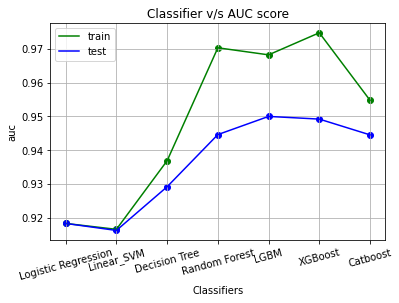

In [ ]:
#plot perfomances of base estimators
plt.plot(perfomance.classifier,perfomance.auc_train,color='g',label='train')
plt.scatter(perfomance.classifier,perfomance.auc_train,color='g')
plt.plot(perfomance.classifier,perfomance.auc_D2,color='b',label='test')
plt.scatter(perfomance.classifier,perfomance.auc_D2,color='b')
plt.xlabel('Classifiers')
plt.ylabel('auc')
plt.title('Classifier v/s AUC score')
plt.xticks(rotation=15)
plt.grid()
plt.legend()

In [ ]:
predictions['target']=np.array(y2)
test_predictions['target']=np.array(y_test)

In [ ]:
#save results to drive
predictions.to_csv('/content/drive/MyDrive/CS1/D2_predictions.csv')
test_predictions.to_csv('/content/drive/MyDrive/CS1/test_predictions.csv')
perfomance.to_csv('/content/drive/MyDrive/CS1/perfomance.csv')

## Tuning the no. of base estimators for stacking
* Experimeting with  different subset of base estimators and a given meta classifier

In [ ]:
def train_base_clf(k):
  '''This function trains the given no.of classifiers on different subsets of data and returns the predictions'''
  LogisticRegression=SGDClassifier(loss='log',class_weight='balanced',max_iter=5000,penalty='l2',alpha=0.0001),
  SVM=SGDClassifier(loss='hinge',class_weight='balanced',max_iter=5000,penalty='l2',alpha=0.001),
  DecisionTree=DecisionTreeClassifier(class_weight='balanced',min_samples_split=5, max_depth=6, criterion='entropy'),
  RandomForest=RandomForestClassifier(class_weight= 'balanced_subsample', max_depth=12, n_estimators=300),
  LGBM=LGBMClassifier(class_weight='balanced',boosting_type='dart',min_child_samples=10, 
                              colsample_bytree=0.6,max_depth=10,n_estimators=300,num_leaves= 40),
  XGBoost=XGBClassifier(colsample_bytree=0.6,scale_pos_weight=80, n_estimators= 50,max_depth=8),
  Catboost=CatBoostClassifier(logging_level='Silent',auto_class_weights='Balanced',max_depth=4,n_estimators=70)
            
  model_list=[LogisticRegression,SVM,DecisionTree,RandomForest,LGBM,XGBoost,[Catboost]]
  predictions=pd.DataFrame()
  test_predictions=pd.DataFrame()
  print('training started..')
  
  for i in range(k):
    current_model=model_list[i%len(model_list)][0]
    
    #sample data
    X,y=sample_df(X1,0.3)   
    
    #train  
    if (i+1) % 5==0:
      print('training base model ',i+1)                           
    calibrated = CalibratedClassifierCV(current_model, method='sigmoid', cv=5)
    calibrated.fit(X,y)
  
    #prediction on holdout data D2
    y_pred=calibrated.predict_proba(X2)[:,1]
  
    #prediction on test data 
    test_pred=calibrated.predict_proba(X_test)[:,1]
  
    #record predictions
    predictions[str(i)]=y_pred
    test_predictions[str(i)]=test_pred
  return predictions,test_predictions

In [ ]:
 def train_stacked(predictions,test_predictions, meta_clf):
  '''This function trains the given meta classifier on given set of predictions by base estimators'''
  #meta classifier
  meta_clf=meta_clf
  X_meta=predictions
  X_test_meta=test_predictions
        
  #train                               
  calibrated = CalibratedClassifierCV(meta_clf, method='sigmoid', cv=5)
  calibrated.fit(X_meta,y2)
      
  #predict probabilities on train data
  yhat=calibrated.predict_proba(X_meta)[:,1]
 
  #prediction on test data 
  test_pred=calibrated.predict_proba(X_test_meta)[:,1]
      
  #compute auc score and 
  auc_train=roc_auc_score(y2,yhat)
  auc_test=roc_auc_score(y_test,test_pred)
  return auc_test,auc_train

In [ ]:
 #list of classifiers
LogisticRegression=SGDClassifier(loss='log',class_weight='balanced',max_iter=5000,penalty='l2',alpha=0.0001),
SVM=SGDClassifier(loss='hinge',class_weight='balanced',max_iter=5000,penalty='l2',alpha=0.001),
DecisionTree=DecisionTreeClassifier(class_weight='balanced',min_samples_split=5, max_depth=6, criterion='entropy'),
RandomForest=RandomForestClassifier(class_weight= 'balanced_subsample', max_depth=12, n_estimators=300),
LGBM=LGBMClassifier(class_weight='balanced',boosting_type='dart',min_child_samples=10, 
                              colsample_bytree=0.6,max_depth=10,n_estimators=300,num_leaves= 40),
XGBoost=XGBClassifier(colsample_bytree=0.6,scale_pos_weight=80, n_estimators= 50,max_depth=8),
Catboost=CatBoostClassifier(logging_level='Silent',auto_class_weights='Balanced',max_depth=4,n_estimators=70)
            
model_list=[(LogisticRegression,'LogisticRegression'),
            (SVM,'SVM'),
            (DecisionTree,'DecisionTree'),
            (RandomForest,'RandomForest'),
            (LGBM,'LGBM'),
            (XGBoost,'XGBoost'),
            ([Catboost],'CatBoost')
            ]

In [ ]:
k=5
perfomance=pd.DataFrame(columns=['no_base_clf','meta_clf','train_auc','test_auc'])
for meta_clf,name in model_list:
  meta_clf=meta_clf[0]
  auc_test,auc_train=train_stacked(predictions,test_predictions, meta_clf)
  perfomance.loc[len(perfomance.index)]=[k,name,auc_train,auc_test]
display(perfomance)

,no_base_clf,meta_clf,train_auc,test_auc
0,5,LogisticRegression,0.949902,0.948313
1,5,SVM,0.949973,0.948339
2,5,DecisionTree,0.958310,0.953639
3,5,RandomForest,0.975921,0.951663
4,5,LGBM,0.958913,0.950676
5,5,XGBoost,0.972356,0.953994
6,5,CatBoost,0.962466,0.954530


In [ ]:
k=10
predictions,test_predictions=train_base_clf(k)
for meta_clf,name in model_list:
  meta_clf=meta_clf[0]
  print('Training metaclassifier: ',name)
  auc_test,auc_train=train_stacked(predictions,test_predictions, meta_clf)
  perfomance.loc[len(perfomance.index)]=[k,name,auc_train,auc_test]
display(perfomance)

training started..
Training metaclassifier:  LogisticRegression
Training metaclassifier:  SVM
Training metaclassifier:  DecisionTree
Training metaclassifier:  RandomForest
Training metaclassifier:  LGBM
Training metaclassifier:  XGBoost
Training metaclassifier:  CatBoost


,no_base_clf,meta_clf,train_auc,test_auc
0,5,LogisticRegression,0.949902,0.948313
1,5,SVM,0.949973,0.948339
2,5,DecisionTree,0.958310,0.953639
3,5,RandomForest,0.975921,0.951663
4,5,LGBM,0.958913,0.950676
5,5,XGBoost,0.972356,0.953994
6,5,CatBoost,0.962466,0.954530
7,10,LogisticRegression,0.950793,0.949670
8,10,SVM,0.951366,0.950159
9,10,DecisionTree,0.958863,0.952696


In [ ]:
perfomance.to_csv('/content/drive/MyDrive/CS1/perfomance180721.csv')

In [ ]:
k=20
predictions,test_predictions=train_base_clf(k)
for meta_clf,name in model_list:
  meta_clf=meta_clf[0]
  print('Training metaclassifier: ',name)
  auc_test,auc_train=train_stacked(predictions,test_predictions, meta_clf)
  perfomance.loc[len(perfomance.index)]=[k,name,auc_train,auc_test]
display(perfomance)

training started..
Training metaclassifier:  LogisticRegression
Training metaclassifier:  SVM
Training metaclassifier:  DecisionTree
Training metaclassifier:  RandomForest
Training metaclassifier:  LGBM
Training metaclassifier:  XGBoost
Training metaclassifier:  CatBoost


,no_base_clf,meta_clf,train_auc,test_auc
0,5,LogisticRegression,0.949902,0.948313
1,5,SVM,0.949973,0.948339
2,5,DecisionTree,0.958310,0.953639
3,5,RandomForest,0.975921,0.951663
4,5,LGBM,0.958913,0.950676
5,5,XGBoost,0.972356,0.953994
6,5,CatBoost,0.962466,0.954530
7,10,LogisticRegression,0.950793,0.949670
8,10,SVM,0.951366,0.950159
9,10,DecisionTree,0.958863,0.952696


In [ ]:
perfomance.to_csv('/content/drive/MyDrive/CS1/perfomance180721.csv')

In [ ]:
k=50
predictions,test_predictions=train_base_clf(k)

training started..
training base model  5
training base model  10
training base model  15
training base model  20
training base model  25
training base model  30
training base model  35
training base model  40
training base model  45
training base model  50


In [ ]:
predictions.to_csv('/content/drive/MyDrive/CS1/predictions.csv')
test_predictions.to_csv('/content/drive/MyDrive/CS1/test_predictions.csv')

In [ ]:
perfomance=pd.read_csv('/content/drive/MyDrive/CS1/perfomance180721.csv')
perfomance=perfomance.drop('Unnamed: 0',axis=1)

In [ ]:
predictions=pd.read_csv('/content/drive/MyDrive/CS1/predictions.csv')
test_predictions=pd.read_csv('/content/drive/MyDrive/CS1/test_predictions.csv')
predictions=predictions.drop('Unnamed: 0',axis=1)
test_predictions=test_predictions.drop('Unnamed: 0',axis=1)

In [ ]:
k=50
for meta_clf,name in model_list:
  meta_clf=meta_clf[0]
  print('Training metaclassifier: ',name)
  auc_test,auc_train=train_stacked(predictions,test_predictions, meta_clf)
  perfomance.loc[len(perfomance.index)]=[k,name,auc_train,auc_test]
  perfomance.to_csv('/content/drive/MyDrive/CS1/perfomance180721.csv')
display(perfomance)

Training metaclassifier:  LogisticRegression
Training metaclassifier:  SVM
Training metaclassifier:  DecisionTree
Training metaclassifier:  RandomForest
Training metaclassifier:  LGBM
Training metaclassifier:  XGBoost
Training metaclassifier:  CatBoost


,no_base_clf,meta_clf,train_auc,test_auc
0,5,LogisticRegression,0.949902,0.948313
1,5,SVM,0.949973,0.948339
2,5,DecisionTree,0.958310,0.953639
3,5,RandomForest,0.975921,0.951663
4,5,LGBM,0.958913,0.950676
5,5,XGBoost,0.972356,0.953994
6,5,CatBoost,0.962466,0.954530
7,10,LogisticRegression,0.950793,0.949670
8,10,SVM,0.951366,0.950159
9,10,DecisionTree,0.958863,0.952696


In [ ]:
k=30
predictions,test_predictions=train_base_clf(k)

training started..
training base model  5
training base model  10
training base model  15
training base model  20
training base model  25
training base model  30


In [ ]:
predictions.to_csv('/content/drive/MyDrive/CS1/predictions30.csv')
test_predictions.to_csv('/content/drive/MyDrive/CS1/test_predictions30.csv')

In [ ]:
#results with different meta-models
for meta_clf,name in model_list:
  meta_clf=meta_clf[0]
  print('Training metaclassifier: ',name)
  auc_test,auc_train=train_stacked(predictions,test_predictions, meta_clf)
  perfomance.loc[len(perfomance.index)]=[k,name,auc_train,auc_test]
  perfomance.to_csv('/content/drive/MyDrive/CS1/perfomance180721.csv')
display(perfomance)

Training metaclassifier:  LogisticRegression
Training metaclassifier:  SVM
Training metaclassifier:  DecisionTree
Training metaclassifier:  RandomForest
Training metaclassifier:  LGBM
Training metaclassifier:  XGBoost
Training metaclassifier:  CatBoost


,no_base_clf,meta_clf,train_auc,test_auc
0,5,LogisticRegression,0.949902,0.948313
1,5,SVM,0.949973,0.948339
2,5,DecisionTree,0.958310,0.953639
3,5,RandomForest,0.975921,0.951663
4,5,LGBM,0.958913,0.950676
5,5,XGBoost,0.972356,0.953994
6,5,CatBoost,0.962466,0.954530
7,10,LogisticRegression,0.950793,0.949670
8,10,SVM,0.951366,0.950159
9,10,DecisionTree,0.958863,0.952696


In [ ]:
#get top scores
perfomance=perfomance.sort_values(by=['test_auc'],ascending=False)

In [ ]:
perfomance

,no_base_clf,meta_clf,train_auc,test_auc
27,50,CatBoost,0.968702,0.956511
25,50,LGBM,0.977161,0.956189
18,20,LGBM,0.974292,0.956008
26,50,XGBoost,0.979505,0.955917
13,10,CatBoost,0.964662,0.955814
32,30,LGBM,0.975435,0.955809
11,10,LGBM,0.971533,0.955565
33,30,XGBoost,0.977992,0.955535
19,20,XGBoost,0.976639,0.955351
20,20,CatBoost,0.967080,0.955337


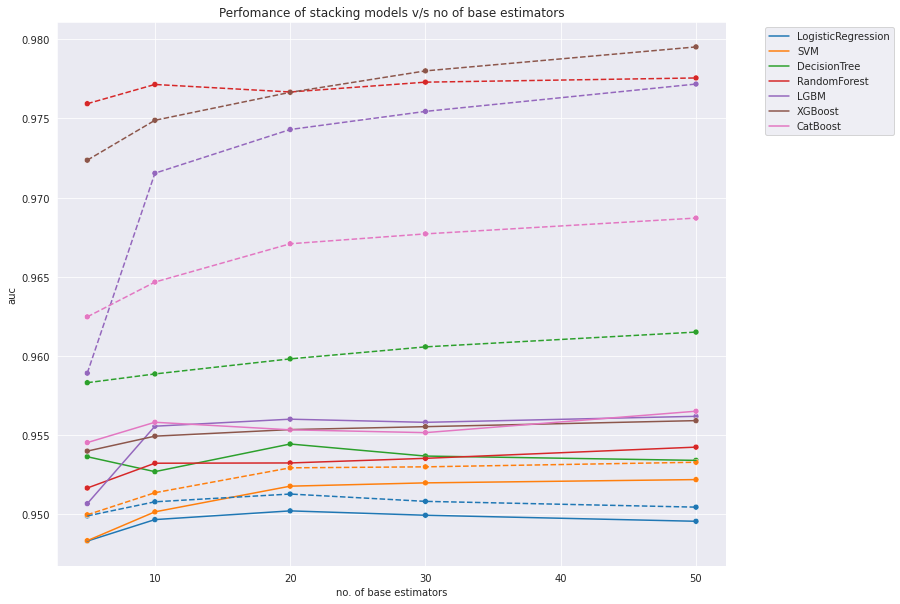

In [ ]:
#plot perfomances of stacked classifiers
sns.set_style("darkgrid")
plt.figure(figsize=(12,10))
sns.lineplot(data=perfomance,x='no_base_clf',y='test_auc',hue='meta_clf')
sns.scatterplot(data=perfomance,x='no_base_clf',y='test_auc',hue='meta_clf',legend=False)
 
sns.lineplot(data=perfomance,x='no_base_clf',y='train_auc',hue='meta_clf',legend=False,linestyle='dashed')
sns.scatterplot(data=perfomance,x='no_base_clf',y='train_auc',hue='meta_clf',legend=False)
 
plt.xlabel('no. of base estimators')
plt.ylabel('auc')
plt.title('Perfomance of stacking models v/s no of base estimators')
plt.legend(bbox_to_anchor=(1.05, 1))

### Obervations:
* Comparing perfomances,top scores are achieved by catboost,LGBM and XGBoost classifiers.
* In these, LGBM and Catboost achieves high auc scores even with 10-20 base learners whereas XGBoost achieves similar result with 50 base learners.


In [ ]:
#experimenting with k=15
predictions=predictions.iloc[:,:15]
test_predictions=test_predictions.iloc[:,:15]
print(predictions.shape,test_predictions.shape)

(771974, 15) (385987, 15)


In [ ]:
model_list=[
            (LGBM,'LGBM'),
            ([Catboost],'CatBoost')
            ]
k=15  
for meta_clf,name in model_list:
  meta_clf=meta_clf[0]
  print('Training metaclassifier: ',name)
  auc_test,auc_train=train_stacked(predictions,test_predictions, meta_clf)
  perfomance.loc[len(perfomance.index)]=[k,name,auc_train,auc_test]
  perfomance.to_csv('/content/drive/MyDrive/CS1/perfomance180721.csv')
display(perfomance.iloc[-2:])      

Training metaclassifier:  LGBM
Training metaclassifier:  CatBoost


,no_base_clf,meta_clf,train_auc,test_auc
35,15,LGBM,0.973787,0.955909
36,15,CatBoost,0.965999,0.955678


In [ ]:
#hyperparameter tuning
clf=LGBMClassifier(class_weight='balanced',
                   boosting_type='dart',
                   min_child_samples=10, 
                   colsample_bytree=0.6)
cv=StratifiedKFold(n_splits = 5)
params={'num_leaves':[20,30,40],
        'max_depth':[7,8,10],
        'n_estimators':[100,200,300,500]
        }
grid_search = GridSearchCV(clf, param_grid=params,scoring='roc_auc',cv=cv)
 
grid_search.fit(predictions, y2)
print("best params:\n",grid_search.best_params_)

best params:
 {'max_depth': 8, 'n_estimators': 100, 'num_leaves': 20}


In [ ]:
#training and eveluating with best classifier
k=15
meta_clf=LGBMClassifier(class_weight='balanced',boosting_type='dart',min_child_samples=10, 
                              colsample_bytree=0.6,max_depth=8,n_estimators=100,num_leaves= 20),
predictions,test_predictions=train_base_clf(k)

In [ ]:
auc_test,auc_train=train_stacked(predictions,test_predictions, meta_clf[0])
print('train auc: ',auc_train)
print('test auc: ',auc_test)

train auc:  0.9636244326914832
test auc:  0.9552587461202098




---



---



---



---



## Feature Selection

In [ ]:
LogisticRegression=SGDClassifier(loss='log',class_weight='balanced',max_iter=5000,penalty='l2',alpha=0.0001),
DecisionTree=DecisionTreeClassifier(class_weight='balanced',min_samples_split=5, max_depth=6, criterion='entropy'),
RandomForest=RandomForestClassifier(class_weight= 'balanced_subsample', max_depth=12, n_estimators=300),

In [ ]:
# Linear model feature importance  #coef
clf=LogisticRegression[0]
clf.fit(X1,y1)
importance = clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))


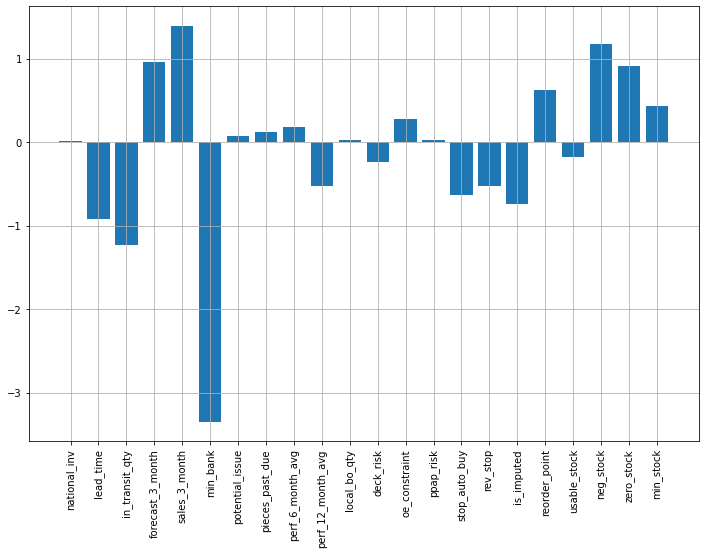

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(list(X1.columns), importance)
plt.xticks(rotation=90)
plt.grid()
plt.show()

Feature: 0, Score: 0.11320
Feature: 1, Score: 0.04309
Feature: 2, Score: 0.03390
Feature: 3, Score: 0.09228
Feature: 4, Score: 0.09193
Feature: 5, Score: 0.00145
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00056
Feature: 8, Score: 0.00601
Feature: 9, Score: 0.00173
Feature: 10, Score: 0.00152
Feature: 11, Score: 0.00193
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00118
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00050
Feature: 17, Score: 0.00204
Feature: 18, Score: 0.60869
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000


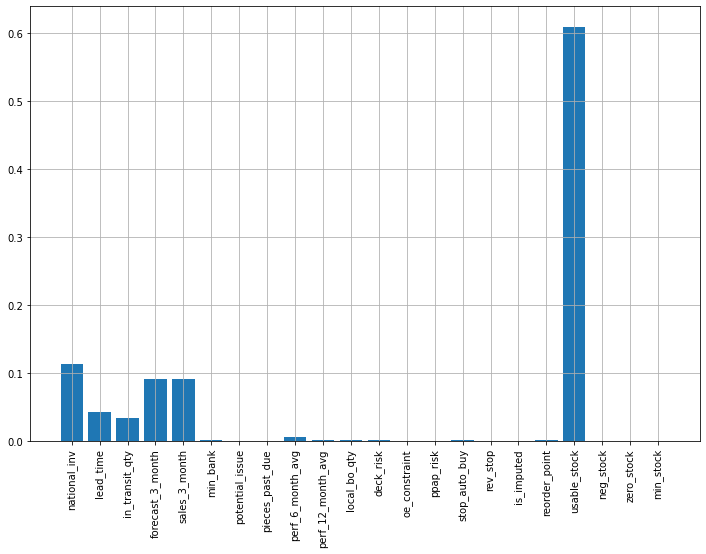

In [ ]:
#tree based model feature importance
clf=DecisionTree[0]
clf.fit(X1,y1)
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.figure(figsize=(12,8))
plt.bar(list(X1.columns), importance)
plt.xticks(rotation=90)
plt.grid()
plt.show()

Feature: 0, Score: 0.12153
Feature: 1, Score: 0.03662
Feature: 2, Score: 0.03264
Feature: 3, Score: 0.15728
Feature: 4, Score: 0.07243
Feature: 5, Score: 0.02422
Feature: 6, Score: 0.00011
Feature: 7, Score: 0.00532
Feature: 8, Score: 0.02606
Feature: 9, Score: 0.02623
Feature: 10, Score: 0.00951
Feature: 11, Score: 0.00630
Feature: 12, Score: 0.00006
Feature: 13, Score: 0.00362
Feature: 14, Score: 0.00253
Feature: 15, Score: 0.00020
Feature: 16, Score: 0.00223
Feature: 17, Score: 0.04732
Feature: 18, Score: 0.26068
Feature: 19, Score: 0.09527
Feature: 20, Score: 0.00835
Feature: 21, Score: 0.06150


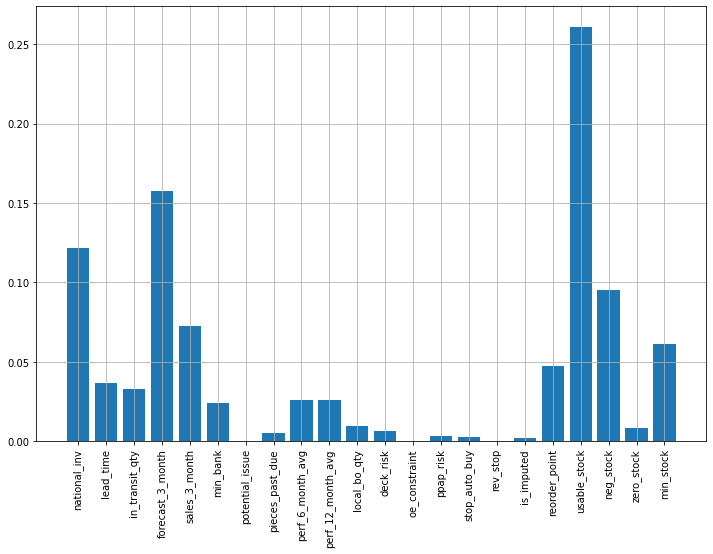

In [ ]:
# tree based enemble feature importance
clf=RandomForest[0]
clf.fit(X1,y1)
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.figure(figsize=(12,8))
plt.bar(list(X1.columns), importance)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [ ]:
#dropping least important features
X1=D1.drop(['potential_issue', 'ppap_risk','local_bo_qty','rev_stop','oe_constraint','forecast_6_month',
            'forecast_9_month','sales_1_month','sales_6_month','sales_9_month'],axis=1)
print(X1.shape)
 
y2=D2['went_on_backorder']
X2=D2.drop(['potential_issue', 'ppap_risk','local_bo_qty','rev_stop','oe_constraint','sku','went_on_backorder','forecast_6_month','forecast_9_month','sales_1_month','sales_6_month','sales_9_month'],axis=1)
print(X2.shape,y2.shape)
 
y_test=test['went_on_backorder']
X_test=test.drop(['potential_issue', 'ppap_risk','local_bo_qty','rev_stop','oe_constraint','sku','went_on_backorder','forecast_6_month','forecast_9_month','sales_1_month','sales_6_month','sales_9_month'],axis=1)
print(X_test.shape,y_test.shape)

(771974, 19)
(771974, 17) (771974,)
(385987, 17) (385987,)


In [ ]:
X1=X1.drop('Unnamed: 0',axis=1)
X2=X2.drop('Unnamed: 0',axis=1)
X_test=X_test.drop('Unnamed: 0',axis=1)
X1.shape,X2.shape,X_test.shape

((771974, 18), (771974, 16), (385987, 16))

In [ ]:
X1.shape,X2.shape,X_test.shape

((771974, 18), (771974, 16), (385987, 16))

In [ ]:
def train_base_clf(k):
  '''This function trains the given no.of classifiers on different subsets of data and returns the predictions'''
  LogisticRegression=SGDClassifier(loss='log',class_weight='balanced',max_iter=5000,penalty='l2',alpha=0.0001),
  SVM=SGDClassifier(loss='hinge',class_weight='balanced',max_iter=5000,penalty='l2',alpha=0.001),
  DecisionTree=DecisionTreeClassifier(class_weight='balanced',min_samples_split=5, max_depth=6, criterion='entropy'),
  RandomForest=RandomForestClassifier(class_weight= 'balanced_subsample', max_depth=12, n_estimators=300),
  LGBM=LGBMClassifier(class_weight='balanced',boosting_type='dart',min_child_samples=10, 
                              colsample_bytree=0.6,max_depth=10,n_estimators=300,num_leaves= 40),
  XGBoost=XGBClassifier(colsample_bytree=0.6,scale_pos_weight=80, n_estimators= 50,max_depth=8),
  Catboost=CatBoostClassifier(logging_level='Silent',auto_class_weights='Balanced',max_depth=4,n_estimators=70)
            
  model_list=[LogisticRegression,SVM,DecisionTree,RandomForest,LGBM,XGBoost,[Catboost]]
  predictions=pd.DataFrame()
  test_predictions=pd.DataFrame()
  print('training started..')
  
  for i in range(k):
    current_model=model_list[i%len(model_list)][0]
    
    #sample data
    X,y=sample_df(X1,0.5)   
    
    #train  
    if (i+1) % 5==0:
      print('training base model ',i+1)                           
    calibrated = CalibratedClassifierCV(current_model, method='sigmoid', cv=5)
    calibrated.fit(X,y)
    joblib.dump(calibrated,'/content/drive/MyDrive/CS1_bo_files/model'+str(i+1)+'.pkl')
    print('saved /content/drive/MyDrive/CS1_bo_files/model'+str(i+1)+'.pkl')
    
    #prediction on holdout data D2
    y_pred=calibrated.predict_proba(X2)[:,1]
  
    #prediction on test data 
    test_pred=calibrated.predict_proba(X_test)[:,1]
  
    #record predictions
    predictions[str(i)]=y_pred
    test_predictions[str(i)]=test_pred
  joblib.dump(predictions,'/content/drive/MyDrive/CS1_bo_files/predictions.pkl')
  joblib.dump(test_predictions,'/content/drive/MyDrive/CS1_bo_files/test_predictions.pkl')
  return predictions,test_predictions

In [ ]:
k=15
predictions,test_predictions=train_base_clf(k)

In [ ]:
def train_stacked(predictions,test_predictions, meta_clf):
  '''This function trains the given meta classifier on given set of predictions by base estimators'''
  #meta classifier
  meta_clf=meta_clf
  X_meta=predictions
  X_test_meta=test_predictions
        
  #train                               
  calibrated = CalibratedClassifierCV(meta_clf, method='sigmoid', cv=5)
  calibrated.fit(X_meta,y2)
      
  joblib.dump(calibrated,'/content/drive/MyDrive/CS1_bo_files/metaclf_.pkl')

  #predict probabilities on train data
  yhat=calibrated.predict_proba(X_meta)[:,1]
 
  #prediction on test data 
  test_pred=calibrated.predict_proba(X_test_meta)[:,1]
      
  #compute auc score and 
  auc_train=roc_auc_score(y2,yhat)
  auc_test=roc_auc_score(y_test,test_pred)
  return auc_test,auc_train

In [ ]:
meta_clf=LGBMClassifier(class_weight='balanced',boosting_type='dart',min_child_samples=10, 
                              colsample_bytree=0.6,max_depth=8,n_estimators=100,num_leaves= 20)

In [ ]:
#15
auc_test,auc_train=train_stacked(predictions,test_predictions, meta_clf)
print('train auc: ',auc_train)
print('test auc: ',auc_test)

train auc:  0.9611948724866899
test auc:  0.9517816774057353




---



---



## Decision Thresholding

In [ ]:
meta_clf=joblib.load('/content/drive/MyDrive/CS1_bo/metaclf_.pkl')

In [ ]:
y_predicted=meta_clf.predict(predictions)
y_proba_predicted=meta_clf.predict_proba(predictions)[:,1]
print('train_auc:',roc_auc_score(y2,y_proba_predicted))
print(classification_report(y2,y_predicted,zero_division=0))

train_auc: 0.9611948724866899
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    766382
           1       0.00      0.00      0.00      5592

    accuracy                           0.99    771974
   macro avg       0.50      0.50      0.50    771974
weighted avg       0.99      0.99      0.99    771974



In [ ]:
y_test_predicted=meta_clf.predict(test_predictions)
y_test_proba_predicted=meta_clf.predict_proba(test_predictions)[:,1]
print('test_auc:',roc_auc_score(y_test,y_test_proba_predicted))
print(classification_report(y_test,y_test_predicted,zero_division=0))

test_auc: 0.9517816774057353
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    383191
           1       0.00      0.00      0.00      2796

    accuracy                           0.99    385987
   macro avg       0.50      0.50      0.50    385987
weighted avg       0.99      0.99      0.99    385987



In [ ]:
from sklearn.metrics import roc_curve

Best Threshold=0.007954, G-Mean=0.899


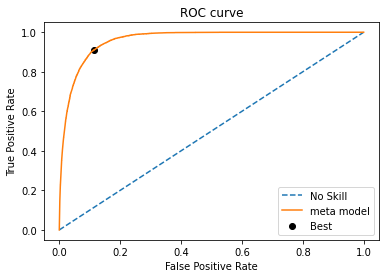

In [ ]:
fpr,tpr,thresholds=roc_curve(y2,y_proba_predicted)
gmeans=np.sqrt(tpr*(1-fpr))
ix=np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='meta model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend()
# show the plot
plt.show()

In [ ]:
threshold=0.007954
y_label_predicted=[(prob>threshold).astype('int32') for prob in y_proba_predicted]
y_test_label_predicted=[(prob>threshold).astype('int32') for prob in y_test_proba_predicted]

In [ ]:
print('train:')
print(classification_report(y2,y_label_predicted))
print('='*60)
print('test:')
print(classification_report(y_test,y_test_label_predicted,))

train:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    766382
           1       0.06      0.91      0.11      5592

    accuracy                           0.89    771974
   macro avg       0.53      0.90      0.52    771974
weighted avg       0.99      0.89      0.93    771974

test:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    383191
           1       0.05      0.89      0.10      2796

    accuracy                           0.89    385987
   macro avg       0.53      0.89      0.52    385987
weighted avg       0.99      0.89      0.93    385987

